In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os

In [23]:
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

In [24]:
data_dir = "data"   # CHANGE path if needed
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Split dataset
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_data, test_data = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(dataset=train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=64, shuffle=False)

class_names = dataset.classes
num_classes = len(class_names)
print("Classes:", class_names)

Classes: ['bike', 'cars', 'cats', 'dogs', 'flowers', 'horses', 'human']


In [25]:
class cnn_improved(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*16*16, 256),  # matches 128x128 input after pooling
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = cnn_improved(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.5)

# --------------------------
# 5. Training Loop
# --------------------------
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    scheduler.step()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")


Epoch [1/20], Loss: 1.7199, Accuracy: 35.09%
Epoch [2/20], Loss: 1.3058, Accuracy: 51.46%
Epoch [3/20], Loss: 1.0910, Accuracy: 60.06%
Epoch [4/20], Loss: 0.9865, Accuracy: 64.29%
Epoch [5/20], Loss: 0.8447, Accuracy: 69.28%
Epoch [6/20], Loss: 0.7689, Accuracy: 70.53%
Epoch [7/20], Loss: 0.6643, Accuracy: 75.03%
Epoch [8/20], Loss: 0.6251, Accuracy: 76.84%
Epoch [9/20], Loss: 0.5547, Accuracy: 80.31%
Epoch [10/20], Loss: 0.5148, Accuracy: 81.90%
Epoch [11/20], Loss: 0.4751, Accuracy: 83.70%
Epoch [12/20], Loss: 0.4309, Accuracy: 84.33%
Epoch [13/20], Loss: 0.4180, Accuracy: 84.81%
Epoch [14/20], Loss: 0.3919, Accuracy: 84.88%
Epoch [15/20], Loss: 0.3309, Accuracy: 88.00%
Epoch [16/20], Loss: 0.3408, Accuracy: 87.38%
Epoch [17/20], Loss: 0.2995, Accuracy: 89.67%
Epoch [18/20], Loss: 0.2973, Accuracy: 89.81%
Epoch [19/20], Loss: 0.2576, Accuracy: 91.54%
Epoch [20/20], Loss: 0.2586, Accuracy: 90.98%


In [27]:
model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

test_acc = 100 * correct / total
print(f"✅ Test Accuracy: {test_acc:.2f}%")


✅ Test Accuracy: 76.73%


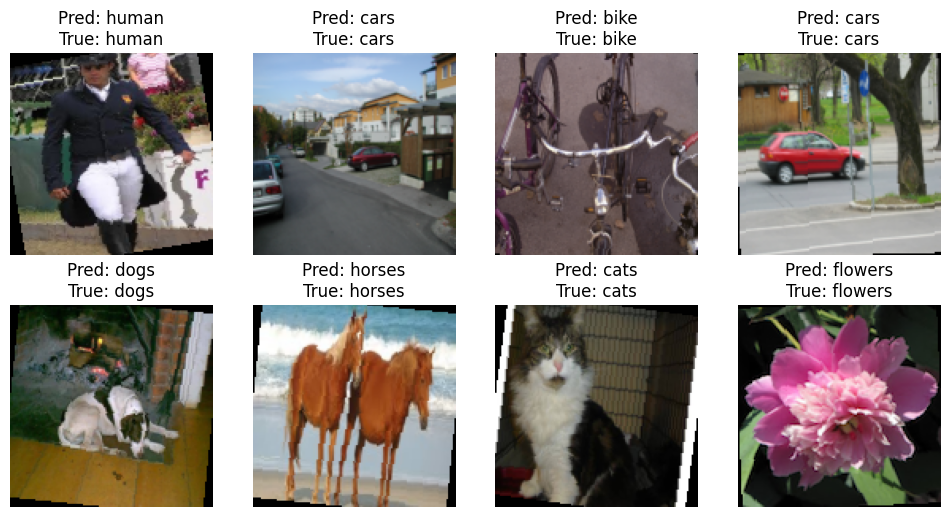

In [28]:
# --------------------------
import matplotlib.pyplot as plt
import numpy as np
def imshow(img, title):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.title(title)
    plt.axis("off")

dataiter = iter(test_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)
outputs = model(images)
_, preds = torch.max(outputs, 1)

plt.figure(figsize=(12,6))
for idx in range(min(8, images.size(0))):
    plt.subplot(2,4,idx+1)
    imshow(images[idx].cpu(), f"Pred: {class_names[preds[idx]]}\nTrue: {class_names[labels[idx]]}")
plt.show()